##### Quantum Data Science 2022/2023
### Lecture 2 - Distance between quantum states and entanglement

<!-- no toc -->
### Contents 

1. [Important functions and libraries](#important)
2. [SWAP Test](#swaptest)
3. [EXERCISE 1 - Inversion test](#inversiontest)
4. [EXERCISE 2 - Hadamard test](#hadamardtest)
5. [EXERCISE 3 - Trace distance](#tracedistance)
6. [EXERCISE 4 - Meyer-Wallach measure](#meyerwallach)

#### 1. Libraries and functions <a id="important"></a>

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

##### Function for executing a quantum circuit 

In [3]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device, shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

##### Function for obtaining basis state probabilities

In [3]:
### POSSIBLE SOLUTION ###
 
def basis_states_probs(counts, shots=1024, n_qubits=1):
   probs = []
   basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

   for b in basis_states:
      c = counts.get(b)
      if c is None:
         probs.append(0)
      else:
         probs.append(counts[b]/shots)


   return probs

#### SWAP Test <a id="swaptest"></a>

<p align="center">
  <img width="500" height="250" src="images/swaptestt.png">
</p>

The swap test can be used to estimate the overlap between arbitrary pure states $|\psi\rangle$ and $|\phi\rangle$. The probability of measuring the ancilla in state $|0\rangle$ is given by: 
$$ P(0) = \frac{1}{2} + \frac{1}{2} |\langle \psi | \phi \rangle |^2$$ 

Thus, the overlap between the states is given by: 

$$|\langle \psi | \phi \rangle |^2 = 2P(0) - 1$$

In [ ]:
### POSSIBLE IMPLEMENTATION OF SWAP TEST ###

def swap_test(qc, ancilla, psi, phi, cr, n_qubits=1):

    overlap = 0 
    
    qc.h(ancilla)

    for qubit in range(n_qubits):
        qc.cswap(ancilla, psi[qubit], phi[qubit])
    qc.h(ancilla)

    qc.measure(ancilla, cr)

    counts = execute_circuit(qc,shots=1024, device=None)
    probs = basis_states_probs(counts, shots=1024, n_qubits=1)
    p0 = probs[0]

    overlap += 2*p0 - 1
    return overlap

### <span style="color: red;">EXERCISE 1</span> - Inversion test <a id="inversiontest"></a>

The inversion test can also be used to estimate the overlap between two pure quantum states with $n$ qubits by preparing the unitary $U_{\psi}$ and the transpose conjugated unitary $U_{\phi}^{\dagger}$ in the same set of $n$ qubits. The overlap is the probability of measuring the all-zero state. 

Prove analytically that the overlap is given by the probability of the all-zero state. 

Implement the inversion test for arbitrary n qubit states.

In [1]:
def inversion_test(psi, phi, shots=1024):
    overlap = 0
    
    n_qubits = psi.num_qubits

    qr=QuantumRegister(n_qubits)
    qc = QuantumCircuit(qr)

    qc = qc.compose(psi,qr)
    qc = qc.compose(phi.inverse(),qr)
    qc.measure_all()

    counts = execute_circuit(qc, shots=1024, reversed=True)

    overlap = basis_states_probs(counts, n_qubits=n_qubits)[0]

    return overlap

Compute the overlap between the states $|GHZ\rangle = \frac{1}{\sqrt{2}}\biggl( |00000\rangle + |11111\rangle \biggr)$ and states $|k_i\rangle = \frac{1}{\sqrt{2}}\biggl( |00000\rangle + |1_{i}\rangle \otimes {|0_{\bar{i}}\rangle} \biggr)$ , $\forall i \in \{[0],[0,1],[0,1,2],\dots,[0,1, \dots , N-1]\}$ and plot the overlaps

Text(0.5, 0, 'CNOTS')

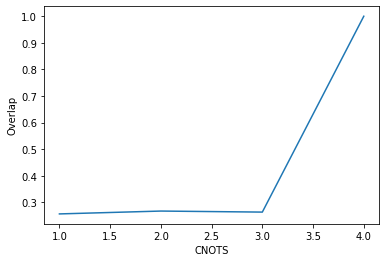

In [ ]:
psi = QuantumCircuit(5)
psi.h(0)
for i in range(4):
    psi.cx(i,i+1)


overlaps = []

for i in range(1,5):
    phi = QuantumCircuit(5)
    phi.h(0)
    for j in range(i):
        phi.cx(j,j+1)
    
    overlaps.append(inversion_test(psi,phi))

plt.plot(list(range(1,5)),overlaps)
plt.ylabel("Overlap")
plt.xlabel("CNOTS")


### <span style="color: red;">EXERCISE 2</span> - Hadamard test <a id="hadamardtest"></a>

The Hadamard test can be used to estimate the real part of the inner product between states $|\psi\rangle$ and $|\phi\rangle$. We use the standard swap test but prepare the states conditionally on the state of the ancilla. Measuring the probability of the ancilla being in the state 0, reveals the real part of the inner product. If we prepare the ancilla in the state $|K\rangle = \frac{1}{\sqrt{2}} (|0\rangle - i|1\rangle)$ and apply the same process, we get the imaginary part of the inner product.

Implement the hadamard test. 

In [ ]:
def hadamard_test(psi, phi, imaginary=False):

    n_qubits = psi.num_qubits
    ancilla = QuantumRegister(1)
    qr = QuantumRegister(n_qubits)
    cr=ClassicalRegister(1)
    qc = QuantumCircuit(ancilla,qr,cr)

    qc.h(0)
    if imaginary:
        qc.p(-np.pi/2,ancilla)# == qc.s(ancilla).inverse()

    psi = psi.to_gate().control(1,ctrl_state='0')
    phi = phi.to_gate().control(1,ctrl_state='1')

    qc = qc.compose(psi,[ancilla]+[i for i in qr])
    qc = qc.compose(phi,[ancilla]+[i for i in qr])

    qc.h(0)

    qc.measure(ancilla,cr)

    counts = execute_circuit(qc)

    probs0 = basis_states_probs(counts)[0]

    return probs0



Test the hadamard test for the GHZ states as in the exercise 4

In [ ]:
psi = QuantumCircuit(5)
psi.h(0)
for i in range(4):
    psi.cx(i,i+1)

phi = QuantumCircuit(5)
phi.h(0)
phi.cx(0,1)

overlap = hadamard_test(psi, phi, imaginary=True)
print(overlap)

0.02734375


### <span style="color: red;">EXERCISE 3</span> - Trace distance <a id="tracedistance"></a>


The fidelity between quantum states $|\langle \psi | \phi \rangle|^2$ only works for the case when both states are pure states. When we have generalized mixed states we need other distance measures. One such measure is the trace distance: 

$$T(\rho, \sigma) = \frac{1}{2} Tr| \rho - \sigma | = \frac{1}{2} \sum_{i}| \lambda_i |$$

where $\rho$ and $\sigma$ are the density matrices associated with the quantum states and $|\lambda_i|$ is the absolute value of the eigenvalue $i$.


In [ ]:
from qiskit.quantum_info import DensityMatrix

qc1 = QuantumCircuit(2)
qc1.h(0)
qc1.cx(0,1)

qc2 = QuantumCircuit(2)
qc2.h([0,1])

state_v1 = execute_circuit(qc1, device="statevector")
state_v2 = execute_circuit(qc2, device="statevector")

rho = DensityMatrix(state_v1)
sigma = DensityMatrix(state_v2)

trace_distance = 1/2 * np.trace(np.abs(rho-rho))

print(trace_distance)


0.0


### <span style="color: red;">EXERCISE 4</span> - Meyer-Wallach measure <a id="meyerwallach"></a>

The Meyer-wallach measure is a technique developed for quantifying the entangling capability of an arbitrary quantum circuit. It can be obtained as:

$$ Q = 2 - \frac{2}{n} \sum_{k=0}^{n-1} Tr(\rho_k^2) $$ 

where $\rho_k$ is the state of the $k^\text{th}$ qubit after tracing out the rest of the system. 

In [ ]:
from qiskit.quantum_info import partial_trace

In [ ]:
def meyer_wallach(qc, n_qubits):

    entanglement = 0
    qubit_list = list(range(n_qubits))

    for k in range(n_qubits):
        
        state_vector = execute_circuit(qc, device="statevector")
        rho_k = partial_trace(state_vector, qubit_list[:k]+qubit_list[k+1:]).data
        trace = np.trace(np.matmul(rho_k,rho_k))
        entanglement += trace

    entanglement /= n_qubits
    
    return 2*(1 - entanglement).real

#### Done ! ciao for now :)